In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import os
import imageio
import shutil
import re

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from plotnine import *

import keras
from keras import Model, layers, optimizers, callbacks, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization
from keras.layers import regularizers, Flatten, Convolution2D, Activation
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Question 1

## 1d conv

In [2]:
def conv_1d(array, kernel, stride=1, padding_element=0, padding_size=0):
    if padding_size>0:
        pad = np.repeat(padding_element, padding_size)
        array = np.hstack([pad, array, pad])
    n = array.size
    k = kernel.size
    indices = np.vstack([np.arange(i, (i+k)) for i in range(0, n-k+1, stride)])
    return (array[indices]*kernel).sum(axis=1)

In [3]:
F =  np.array([int(i) for i in '1 2 1 3 2 3 1 2 3 8 7 8 9 9 7 8'.split(' ')])
W1 = np.array([1, 1, 1])
W2 = np.array([1, 0, -1])
print(F)
print(W1)
print(W2)

[1 2 1 3 2 3 1 2 3 8 7 8 9 9 7 8]
[1 1 1]
[ 1  0 -1]


In [4]:
print(conv_1d(F, W1))
print(conv_1d(F, W2))

[ 4  6  6  8  6  6  6 13 18 23 24 26 25 24]
[ 0 -1 -1  0  1  1 -2 -6 -4  0 -2 -1  2  1]


## 2d convs

In [5]:
def plot_figures(figures, nrows = 1, ncols=2, ht=18.5, wd=10.5):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    fig.set_size_inches(ht, wd, forward=True)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional


def conv_2d_1channel(image, kernel_2d, stride=1, padding_element=0, padding_size=0):
    image_shape = image.shape
    h = image_shape[0]
    w = image_shape[1]
    
    kernel_shape = kernel_2d.shape
    h_k = kernel_shape[0]
    w_k = kernel_shape[1]
    final_shape = len(range(0, h-h_k+1, stride)), len(range(0, w-w_k+1, stride))
    new_image = np.zeros(final_shape)
    for i in range(0, h-h_k+1, stride):
        for j in range(0, w-w_k+1, stride):
            window = image[i:(i+h_k), j:(j+w_k)]
            new_image[i,j] = (window*kernel_2d).sum()
            
#     new_image = new_image/(255*h_k*w_k) if scale else new_image
    plot_figures({'original': I, 'transformed': new_image})     
    return new_image

(array([[164, 188, 164, 161, 195],
        [178, 201, 197, 150, 137],
        [174, 168, 181, 190, 184],
        [131, 179, 176, 185, 198],
        [ 92, 185, 179, 133, 167]]),
 <matplotlib.image.AxesImage at 0x7fc4cf348470>)

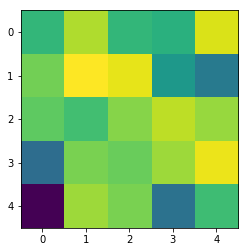

In [6]:
rows = '''164 188 164 161 195
178 201 197 150 137
174 168 181 190 184
131 179 176 185 198
92 185 179 133 167'''.split('\n')

elements = [r.split(' ') for r in rows]
I = np.array([int(element) for r in elements for element in r]).reshape((5, 5))
I, imshow(I)

array([[1615., 1600., 1559.],
       [1585., 1627., 1598.],
       [1465., 1576., 1593.]])

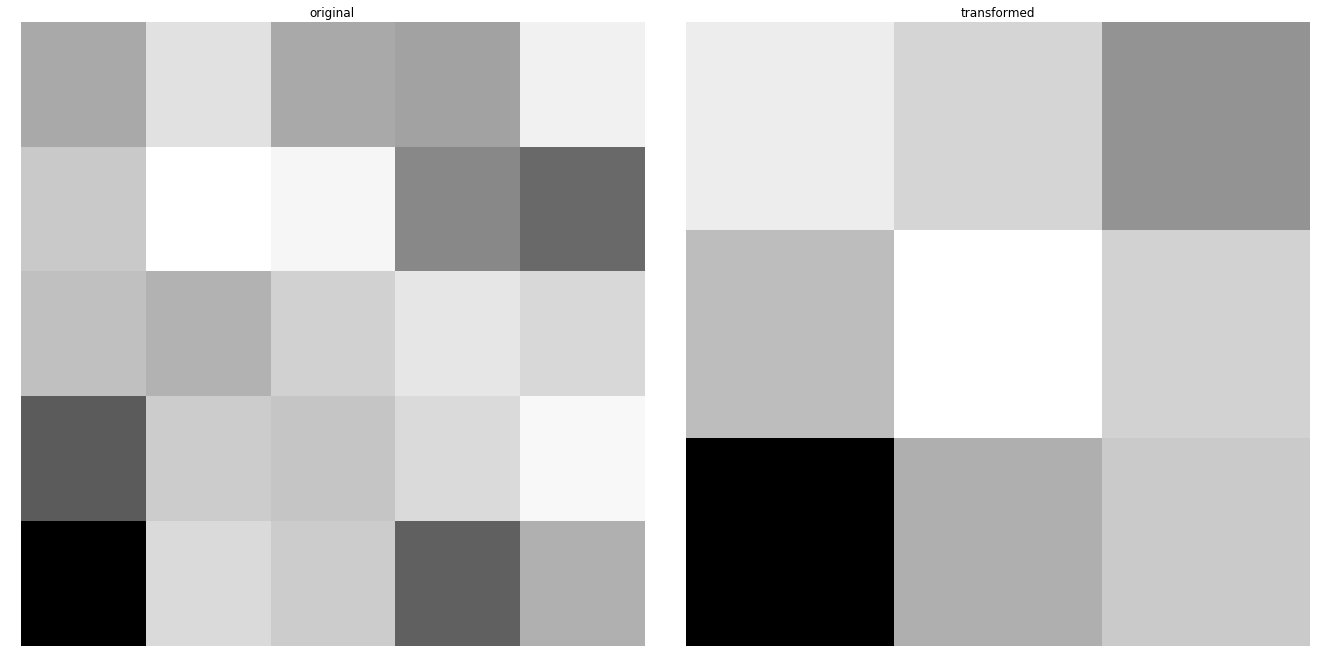

In [7]:
F1 = np.ones((3, 3))
conv_2d_1channel(I, F1)

array([[ -13.,   43.,   64.],
       [-112.,  -29.,  110.],
       [ -50.,  -44., -133.]])

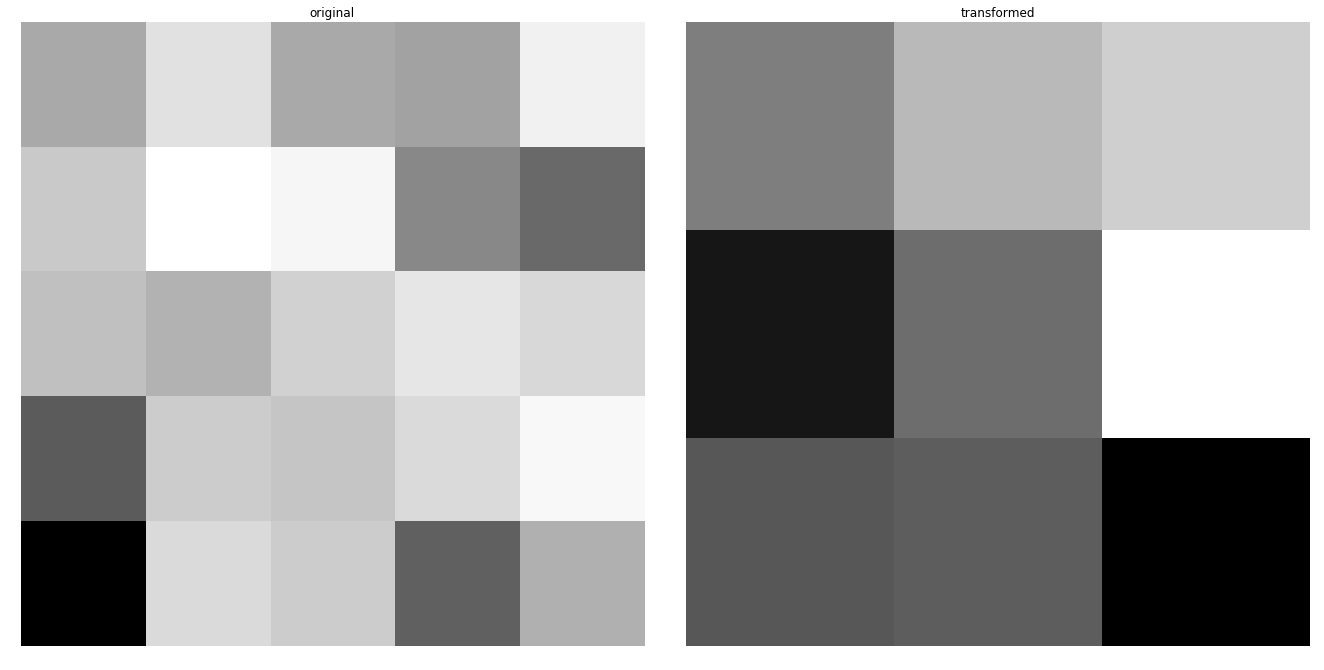

In [8]:
F2 = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])
conv_2d_1channel(I, F2)

array([[395., 370., -59.],
       [ 95., 183., 302.],
       [325., 184., 257.]])

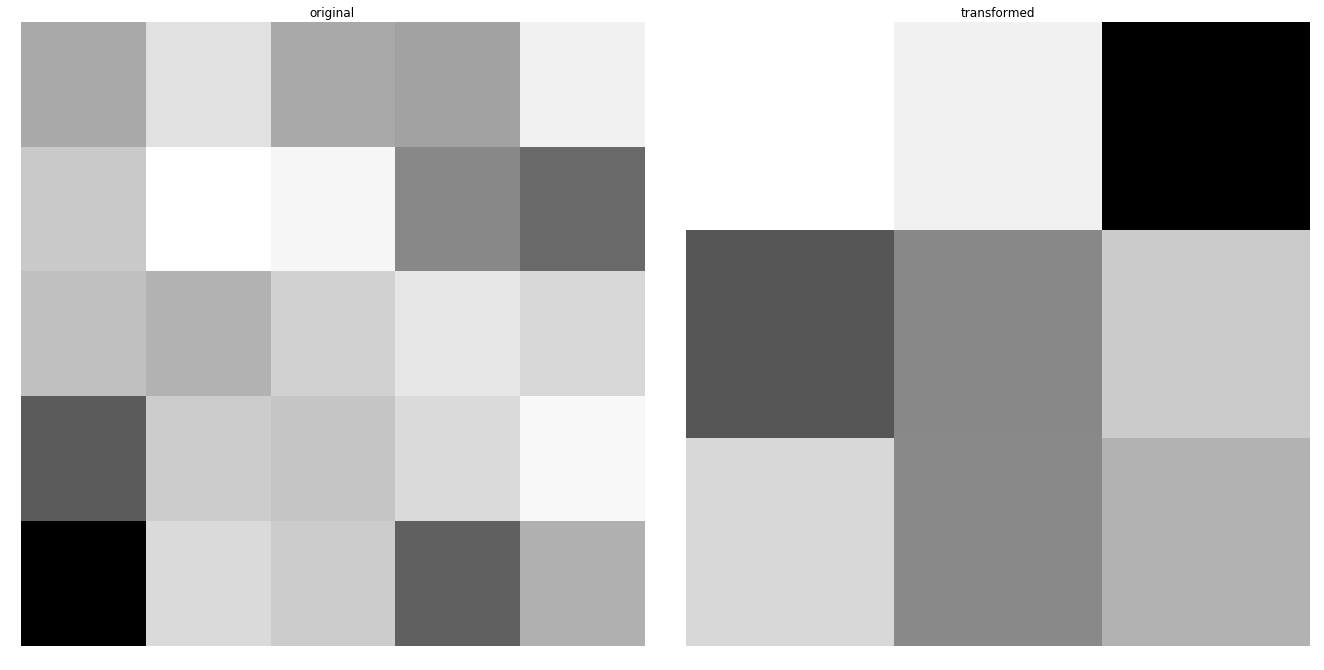

In [9]:
F2 = np.array([
    [-1, -1, -1],
    [-1, 9, -1],
    [-1, -1, -1]
])
conv_2d_1channel(I, F2)

# Question 2

In [10]:
path_data_yale = 'data/yalefaces/'
img_files = os.listdir(path_data_yale)
img_files[:5]

['subject13.normal.gif',
 'subject14.happy.gif',
 'subject03.noglasses.gif',
 'subject01.wink.gif',
 'subject05.noglasses.gif']

In [11]:
for i in img_files:
    path_image = path_data_yale+i
    if '.gif' not in path_image:
        new_name = path_image+'.gif'
        shutil.move(path_image, new_name)
img_files = os.listdir(path_data_yale)

In [12]:
def read_images(resize_perc=0.5):
    img = []
    class_ = []
    subject = []

    re_subject_no = re.compile('^subject(\d+)')
    re_class = re.compile('^subject\d+.([A-Za-z]+)')

    for i in img_files:
        subject.append(int(re.findall(re_subject_no, i)[0]))
        class_.append(re.findall(re_class, i)[0])
        path_image = path_data_yale+i
        img_array = Image.open(path_image)
        img_array_np = np.array(img_array)
        img_array = img_array.resize((round(img_array_np.shape[0]*resize_perc), 
                                      round(img_array_np.shape[1]*resize_perc)))
        img.append(np.expand_dims(np.array(img_array), axis=0))
    
    img = np.vstack(img)
    subject = np.array(subject)-1

    le = LabelEncoder()
    class_ = le.fit_transform(class_)
    
    return img, class_, subject

img, class_, subject = read_images(resize_perc=0.2)

print(img.shape)
print(class_.shape)
print(subject.shape) 

(165, 64, 49)
(165,)
(165,)


In [13]:
def split(img_class_subs, 
          test_samples_per_subject=1,
          val_samples_per_subject=1, 
          create_validation_set=False,
          seed=np.random.randint(0, 1000, size=1)):
    np.random.seed(seed)
    imgs, subjects, classes = img_class_subs
    order = subjects.argsort()
    imgs, subjects, classes = imgs[order], subjects[order], classes[order]
    sub_counts = np.unique(subjects, return_counts=True)    
    selections = np.hstack([np.repeat(0, sub_counts[1][1]-test_samples_per_subject), 
                            np.repeat(1, test_samples_per_subject)])
    test_selection = np.vstack(
                [np.expand_dims(
                    np.random.choice(selections, 
                                     size=selections.size, 
                                     replace=False), 
                    axis=0) 
                 for i in range(sub_counts[0].size)]
            )
    test_selection = (test_selection==1).reshape((-1))
    train_selection = (test_selection==0).reshape((-1))
    test_set = (imgs[test_selection], subjects[test_selection], classes[test_selection])
    train_set = (imgs[train_selection], subjects[train_selection], classes[train_selection])
    if create_validation_set:
        train_set, val_set = split(train_set, test_samples_per_subject=val_samples_per_subject)
        return train_set, val_set, test_set
    else:
        return unison_shuffled_copies(*train_set), unison_shuffled_copies(*test_set)
    
def unison_shuffled_copies(a, b, c):
    p = np.random.permutation(a.shape[0])
    return a[p], b[p], c[p]

(135, 64, 49) (135,) (135,)
(30, 64, 49) (30,) (30,)


(<matplotlib.image.AxesImage at 0x7fc4ca705ef0>, 0)

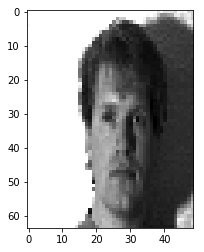

In [14]:
train_set, test_set = split((img, subject, class_), test_samples_per_subject=2, seed=1)
tr_X_org = train_set[0]/255
tr_X = tr_X_org.reshape(tr_X_org.shape[0], -1)
tr_y = train_set[1]

ts_X_org = test_set[0]/255
ts_X = ts_X_org.reshape(ts_X_org.shape[0], -1)
ts_y = test_set[1]

h = train_set[0][0].shape[0]
w = train_set[0][0].shape[1]

print(tr_X_org.shape, tr_y.shape, train_set[2].shape)
print(ts_X_org.shape, ts_y.shape, test_set[2].shape)
imshow(test_set[0][0]), test_set[1][0]

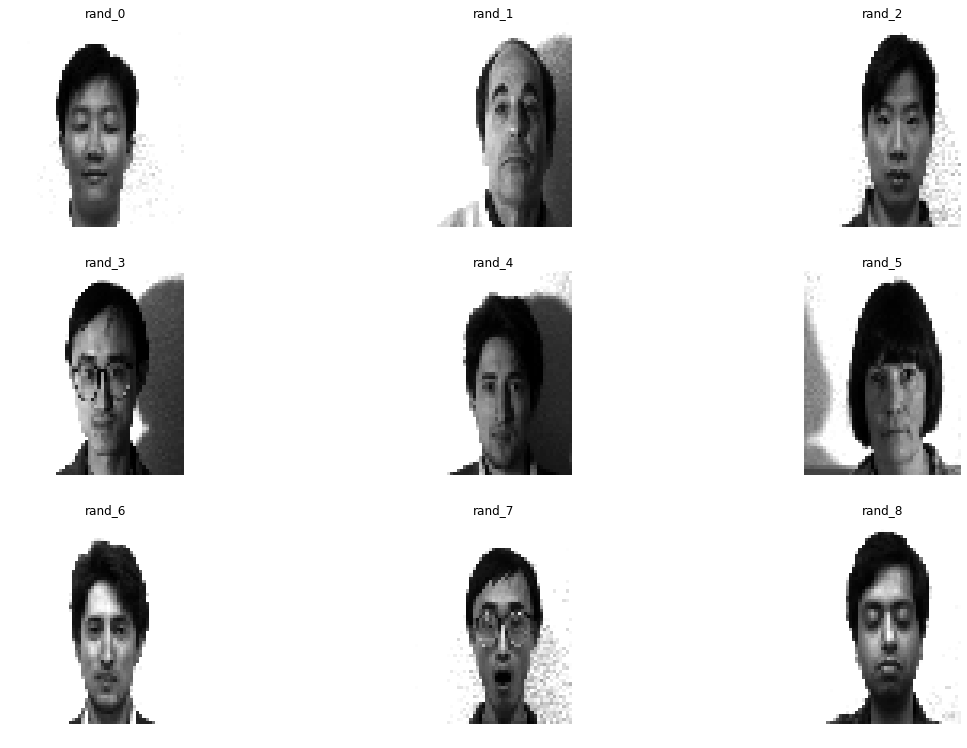

In [15]:
plot_figures({f'rand_{i}':img[np.asscalar(np.random.randint(0, 166, 1))] for i in range(9)}, nrows=3, ncols=3)

In [16]:
class PCA_image:
    def __init__(self, k):
        self.k = k

    def reshape(self, img: np.array):
        return img.reshape((img.shape[0], -1))

    def fit(self, X):
        self.X_org = X.copy()
        self.X = self.reshape(X.copy())
        self.mean_ = self.X.mean(axis=0)
        self.X = self.X - self.mean_
        self.cov = np.cov(self.X, rowvar=False)
        eig = np.linalg.eigh(self.cov)
        eig_ord = np.flipud(eig[0].argsort())
        self.eig_vals = eig[0][eig_ord]
        self.eig_vectors = eig[1].T[eig_ord]

    def get_eig_vecs(self, k=None):
        k = self.k if k is None else k
        return self.eig_vectors[:k]

    def transform(self, ts_X, k=None):
        eig_vecs = self.get_eig_vecs(k)
        ts_X = self.reshape(ts_X) - self.mean_
        return ts_X.dot(eig_vecs.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, ts_X_transformed, k=None):
        eig_vecs = self.get_eig_vecs(k)
        return ts_X_transformed.dot(eig_vecs) + self.mean_

    def compress(self, ts_X, k=None):
        return self.inverse_transform(self.transform(ts_X, k), k)
    
    def explained_variance(self, X=None):
        if X is None:
            X = self.X
        X_trans = self.transform(X, self.eig_vals.shape[0])
        return X_trans.var(axis=0)
    
    def explained_variance_ratio(self, X=None):
        var = self.explained_variance(X)
        return var/var.sum()
    
    

In [17]:
k=2
pca = PCA_image(k=k)
pca.fit(img)

In [18]:
pca.eig_vectors

array([[-0.0030331 , -0.00205975, -0.00196088, ...,  0.01717357,
         0.0168772 ,  0.01497683],
       [ 0.00707034,  0.00559396,  0.00568993, ...,  0.02431243,
         0.0235838 ,  0.02281566],
       [-0.00352691, -0.00397031, -0.00446629, ..., -0.0058697 ,
        -0.00160836, -0.00208187],
       ...,
       [ 0.        ,  0.1005919 , -0.04348988, ...,  0.03397898,
        -0.00334528, -0.00398217],
       [ 0.        , -0.42688774,  0.39595015, ...,  0.00788925,
        -0.01255176, -0.01179406],
       [ 0.        , -0.40885082, -0.39373438, ..., -0.01113761,
         0.00585843,  0.0086509 ]])

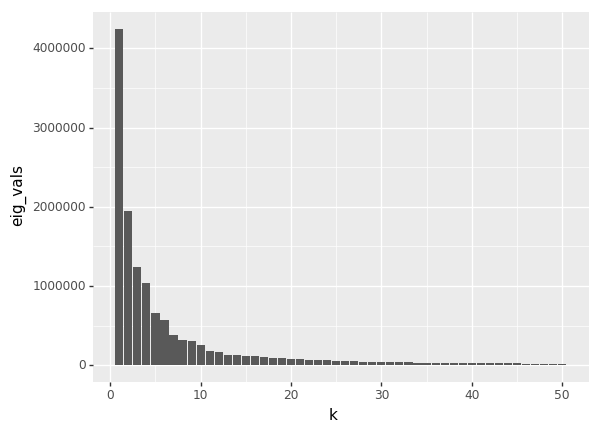

<ggplot: (8791267049613)>

In [86]:
df_energy = pd.DataFrame({'k':np.arange(pca.eig_vals.shape[0])+1, 'eig_vals':pca.eig_vals}).iloc[:k]
ggplot(aes('k', 'eig_vals'), df_energy) + geom_col()

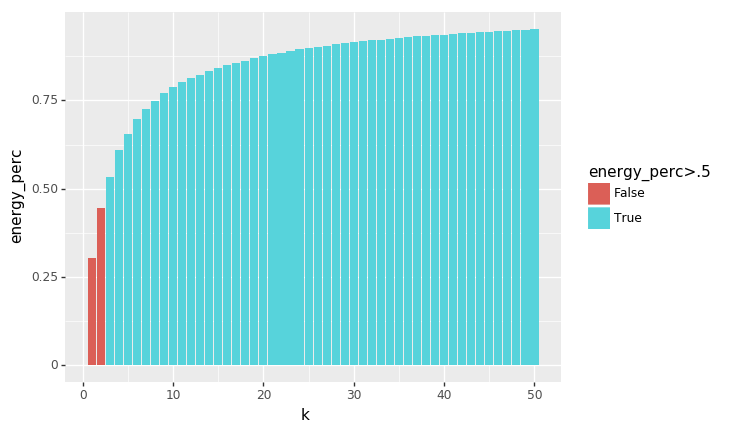

<ggplot: (-9223363245597662099)>

In [99]:
df_energy_perc = df_energy = pd.DataFrame({'k':np.arange(pca.eig_vals.shape[0])+1, 'energy_perc':pca.eig_vals.cumsum()/pca.eig_vals.sum()}).iloc[:k] 
ggplot(aes('k', 'energy_perc', fill='energy_perc>.5'), df_energy_perc) + geom_col()

In [21]:
def reconstruct_set(n_components, X):    
    return pca.compress(X, n_components).reshape((X.shape[0], h, w))

def get_reconstructed_progress(ncomps=range(1, 135, 5)):
    return {n_comp:reconstruct_set(n_comp, img) for n_comp in ncomps}
    
reconstructed_progress = get_reconstructed_progress()

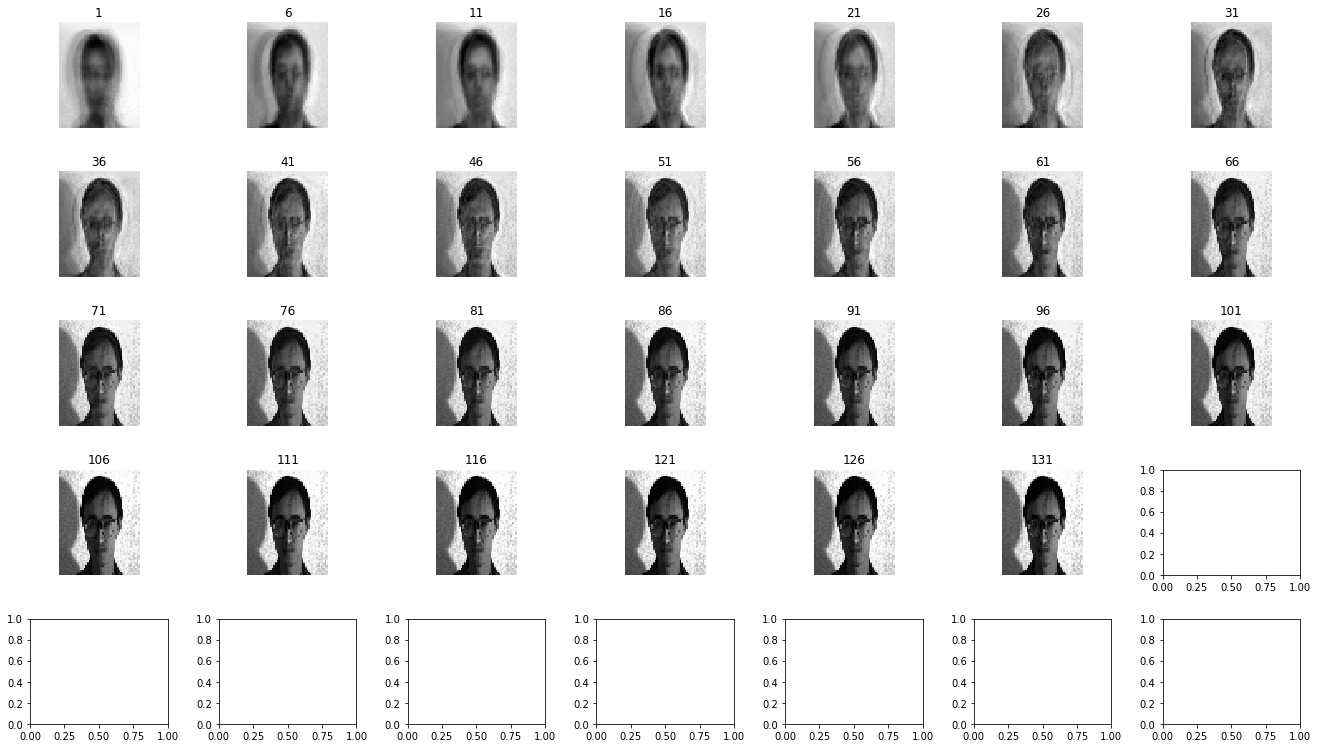

In [22]:
def plot_reconstructed_progress_for_image(image_index=0):
    img = {k:v[image_index] for k,v in reconstructed_progress.items()} #range(len(reconstructed_progress))
    plot_figures(img, nrows=5, ncols=7)

plot_reconstructed_progress_for_image(34)

## Scikit PCA

In [19]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

model_pipeline = Pipeline([
                        ('pca', PCA(5)),
                        ('rf', RandomForestClassifier(n_estimators=100))
                    ])


param_grid = {
    'pca__n_components':range(1, 30, 3)
}

model_cv_best = GridSearchCV(model_pipeline, 
                             param_grid=param_grid, 
                             cv=7, 
                             verbose=True, 
                             n_jobs=-1, 
                             iid=False,
                            return_train_score=False)

model_cv_best.fit(tr_X, tr_y)
model_cv_best.score(ts_X, ts_y)

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.4s finished


0.8666666666666667

array([94.7133992 , 63.39079604, 51.34386986])

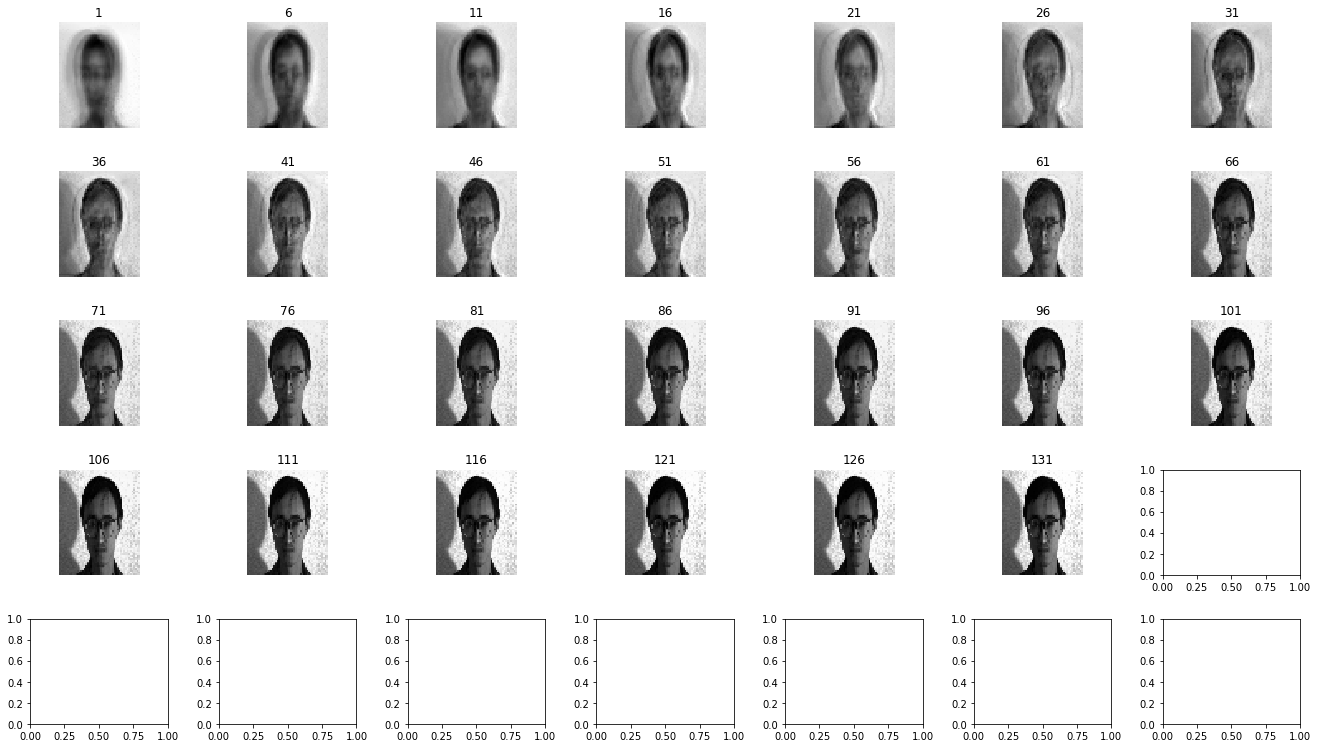

In [48]:
def reconstruct_set(n_components, X):    
    pca = PCA(n_components)
    components = pca.fit_transform(X)
    return pca.inverse_transform(components).reshape((components.shape[0], h, w))

def get_reconstructed_progress(ncomps=range(1, 135, 5)):
    return {n_comp:reconstruct_set(n_comp, img.copy().reshape(img.shape[0], -1)) for n_comp in ncomps}
    

reconstructed_progress = get_reconstructed_progress()
def plot_reconstructed_progress_for_image(image_index=0):
    img = {k:v[image_index] for k,v in reconstructed_progress.items()} #range(len(reconstructed_progress))
    plot_figures(img, nrows=5, ncols=7)

plot_reconstructed_progress_for_image(34)

pca_2 = PCA(3)
components = pca_2.fit_transform(tr_X)
pca_2.singular_values_

In [20]:
pca_2 = PCA(135)
components = pca_2.fit_transform(img.copy().reshape(img.shape[0], -1))
pca_2.explained_variance_ratio_[:3].sum()

0.5343284305924059

In [22]:
pca_2.components_, pca.eig_vectors

(array([[-0.0030331 , -0.00205975, -0.00196088, ...,  0.01717357,
          0.0168772 ,  0.01497683],
        [-0.00707034, -0.00559396, -0.00568993, ..., -0.02431243,
         -0.0235838 , -0.02281566],
        [-0.00352691, -0.00397031, -0.00446629, ..., -0.0058697 ,
         -0.00160836, -0.00208187],
        ...,
        [ 0.00137207,  0.0169686 ,  0.00775332, ...,  0.01834624,
          0.01359653,  0.01580744],
        [ 0.00311106,  0.00190179,  0.00168456, ..., -0.00574815,
         -0.0056576 , -0.00395644],
        [-0.00185327,  0.00263914, -0.00400354, ..., -0.00718653,
          0.00967593,  0.01516655]]),
 array([[-0.0030331 , -0.00205975, -0.00196088, ...,  0.01717357,
          0.0168772 ,  0.01497683],
        [ 0.00707034,  0.00559396,  0.00568993, ...,  0.02431243,
          0.0235838 ,  0.02281566],
        [-0.00352691, -0.00397031, -0.00446629, ..., -0.0058697 ,
         -0.00160836, -0.00208187],
        ...,
        [ 0.        ,  0.1005919 , -0.04348988, ...,  

In [73]:
pca_2.explained_variance_ratio_

array([3.05040138e-01, 1.39862638e-01, 8.94256551e-02, 7.45561760e-02,
       4.72689778e-02, 4.11971469e-02, 2.75062467e-02, 2.29619198e-02,
       2.23399179e-02, 1.86026406e-02, 1.33263873e-02, 1.17208178e-02,
       9.38966273e-03, 9.13532059e-03, 8.74110485e-03, 8.03493326e-03,
       7.38998696e-03, 6.72312036e-03, 6.33986662e-03, 5.98901766e-03,
       5.31474197e-03, 4.83618598e-03, 4.52597839e-03, 4.28096913e-03,
       3.87329768e-03, 3.76227912e-03, 3.42297164e-03, 3.14868950e-03,
       3.04581798e-03, 2.81342766e-03, 2.79075437e-03, 2.63180095e-03,
       2.46900831e-03, 2.36111877e-03, 2.31911673e-03, 2.12908788e-03,
       2.01731605e-03, 1.93604834e-03, 1.84140886e-03, 1.75924216e-03,
       1.72837630e-03, 1.67106770e-03, 1.62424508e-03, 1.58918084e-03,
       1.55976621e-03, 1.45914787e-03, 1.43118285e-03, 1.35576417e-03,
       1.34259284e-03, 1.31445175e-03, 1.29724129e-03, 1.23991726e-03,
       1.20308618e-03, 1.17421034e-03, 1.12725541e-03, 1.08030788e-03,
      

## CNN

In [103]:
train_subset, validation_set = split(train_set, test_samples_per_subject=2, seed=2)


tr_y = train_set[1]
tr_sub_y = train_subset[1]
val_y = validation_set[1]
ts_y = test_set[1]

tr_sub_X = train_subset[0].reshape(train_subset[0].shape[0], h, w, 1)/255
tr_X = train_set[0].reshape(train_set[0].shape[0], h, w, 1)/255
val_X = validation_set[0].reshape(validation_set[0].shape[0], h, w, 1)/255
ts_X = test_set[0].reshape(test_set[0].shape[0], h, w, 1)/255
print(tr_sub_X.shape)


# ohe = OneHotEncoder()
# tr_sub_y_ohe = ohe.fit_transform(tr_sub_y.reshape(-1, 1)).todense()
# tr_y_ohe = ohe.transform(tr_y.reshape(-1, 1)).todense()
# val_y_ohe = ohe.transform(val_y.reshape(-1, 1)).todense()
# ts_y_ohe = ohe.transform(ts_y.reshape(-1, 1)).todense()

(105, 243, 320, 1)


4

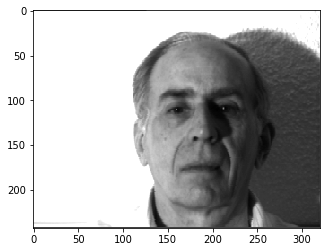

In [25]:
imshow(tr_sub_X[1][:,:,0])
# tr_sub_y_ohe[1], 
tr_sub_y[1]

In [98]:
def conv_block(n, input_layer=False):
    conv_layer = (Convolution2D(n, (3,3), input_shape=tr_sub_X.shape[1:]) 
                  if input_layer 
                  else Convolution2D(n, (3,3)))
    return Sequential([
        conv_layer,
#         BatchNormalization(),
        Activation(activation='relu'),
        Dropout(0.35),
        MaxPooling2D(strides=(2, 2))
    ])
    

def Model_Factory(conv_activations=[10, 15, 25, 25, 25, 25]):
    # CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->
    # Conv > Normalization > Activation > Dropout > Pooling
    
    model = Sequential()
    
    for i,n in enumerate(conv_activations):
        model.add(conv_block(n, input_layer=(i==0)))
    
    model.add(Flatten())
    model.add(Dense(15, activation='softmax'))
    
    model.compile(optimizer=optimizers.rmsprop(lr=1e-3), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['acc'])
    
    print(model.summary())
    
#     model.score = model.evaluate

    return model 

def get_callbacks(vbose=False):
    callback_list = [
        callbacks.ModelCheckpoint('data/best_model_acc.h5', 
                                  monitor='val_acc', 
                                  save_best_only=True, 
                                  verbose=vbose),
        callbacks.ModelCheckpoint('data/best_model_loss.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=vbose),
        callbacks.ReduceLROnPlateau(factor=0.9, 
                                    monitor='val_acc', 
                                    save_best_only=True, 
                                    verbose=vbose)
    ]
    return callback_list

model = Model_Factory()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_37 (Sequential)   (None, 120, 159, 10)      100       
_________________________________________________________________
sequential_38 (Sequential)   (None, 59, 78, 15)        1365      
_________________________________________________________________
sequential_39 (Sequential)   (None, 28, 38, 25)        3400      
_________________________________________________________________
sequential_40 (Sequential)   (None, 13, 18, 25)        5650      
_________________________________________________________________
sequential_41 (Sequential)   (None, 5, 8, 25)          5650      
_________________________________________________________________
sequential_42 (Sequential)   (None, 1, 3, 25)          5650      
_________________________________________________________________
flatten_6 (Flatten)          (None, 75)                0         
__________

In [90]:
model.fit(tr_sub_X, tr_sub_y, 
          epochs=100, batch_size=10, 
          validation_data =(val_X, val_y), 
          callbacks=get_callbacks())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_23 (Sequential)   (None, 120, 159, 10)      100       
_________________________________________________________________
sequential_24 (Sequential)   (None, 59, 78, 15)        1365      
_________________________________________________________________
sequential_25 (Sequential)   (None, 28, 38, 25)        3400      
_________________________________________________________________
sequential_26 (Sequential)   (None, 13, 18, 25)        5650      
_________________________________________________________________
sequential_27 (Sequential)   (None, 5, 8, 25)          5650      
_________________________________________________________________
sequential_28 (Sequential)   (None, 1, 3, 25)          5650      
_________________________________________________________________
flatten_4 (Flatten)          (None, 75)                0         
__________

In [37]:
model.load_weights('data/best_model.h5')
model.evaluate(ts_X, ts_y), model.evaluate(val_X, val_y)

30/30 [==============================] - 0s 8ms/step


([1.0662306547164917, 0.8333333134651184], [1.110913634300232, 1.0])

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

model_skeras = KerasClassifier(build_fn=Model_Factory, 
                                epochs=10, 
                                batch_size=10, 
                                verbose=1,
        #                         validation_data =(val_X, val_y),
#                                 callbacks=get_callbacks()
                              )

results = cross_val_score(model_skeras, tr_X, tr_y, cv=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_51 (Sequential)   (None, 120, 159, 10)      100       
_________________________________________________________________
sequential_52 (Sequential)   (None, 59, 78, 15)        1365      
_________________________________________________________________
sequential_53 (Sequential)   (None, 28, 38, 25)        3400      
_________________________________________________________________
sequential_54 (Sequential)   (None, 13, 18, 25)        5650      
_________________________________________________________________
sequential_55 (Sequential)   (None, 5, 8, 25)          5650      
_________________________________________________________________
sequential_56 (Sequential)   (None, 1, 3, 25)          5650      
_________________________________________________________________
flatten_8 (Flatten)          (None, 75)                0         
__________

In [105]:
results

array([0.3382353 , 0.41791046])